In [1]:
%matplotlib inline
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import os
import shutil

import torchvision.transforms as transforms
import torch
from models.experimental import attempt_load
from utils.general import non_max_suppression
from utils.torch_utils import select_device
from utils.feature_extraction import preprocess_image, detect_objects_yolov7, visualize_detections,\
    inspect_model_layers, extract_penultimate_features, extract_features_with_detection, \
    get_central_bbox_features, debug_feature_extraction, extract_features_batch
from utils.bbox_feature_extraction import extract_bbox_features, extract_all_bbox_features,\
get_central_bbox_roi_features,extract_roi_features_batch


In [2]:
# Load YOLOv7 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = attempt_load('yolov7.pt', map_location=device)  # Load weights
model.eval()  # Set to evaluation mode

/home/ehajizad/dev/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(w, map_location=map_location)  # load


Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


/home/ehajizad/dev/cl_venv/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): Conv(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (3): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (4): Conv(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (5): Conv(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU(inplace=True)
    )
    (6): Conv(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (7): Conv(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), strid

In [3]:
# Example: Extract penultimate layer features for feature representation
import glob

class_names = ["Snowmobile", "Helicopter", "Airplane"]
class_id = 1
image_paths = glob.glob("/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/"+class_names[class_id]+"/*.jpg")

# Example with a single image
if image_paths:
    image_path = image_paths[0]
    print(f"Processing image: {image_path}")
    
    # Preprocess the image
    image_tensor = preprocess_image(image_path, image_size=640)
    
    # First, debug what we get from different layers
    print("=== DEBUG: Testing different layers ===")
    test_layers = ['model.99', 'model.103', 'model.105', 'model.101', 'model.24']
    
    for layer_name in test_layers:
        print(f"\n--- Testing layer: {layer_name} ---")
        debug_output = debug_feature_extraction(model, image_tensor, layer_name)
        if debug_output is not None:
            print(f"Successfully captured output from {layer_name}")
        else:
            print(f"No output captured from {layer_name}")
    
    print("\n=== ACTUAL FEATURE EXTRACTION ===")
    # Try with a layer that showed good spatial dimensions
    print("Testing feature extraction with model.99:")
    features_99 = extract_penultimate_features(model, image_tensor, 'model.99')
    if features_99 is not None:
        print(f"Features from model.99 - Shape: {features_99.shape}, First 10: {features_99[:10]}")
    
    print("\nTesting feature extraction with model.103:")
    features_103 = extract_penultimate_features(model, image_tensor, 'model.103')
    if features_103 is not None:
        print(f"Features from model.103 - Shape: {features_103.shape}, First 10: {features_103[:10]}")
    
    print("\nTesting feature extraction with default (model.105):")
    # Extract features and detections for the central bounding box
    central_detection, features = get_central_bbox_features(model, image_tensor, conf_threshold=0.05)
    
    if features is not None:
        print(f"Feature vector shape: {features.shape}")
        print(f"Feature vector (first 10 values): {features[:10]}")
        
        if central_detection is not None:
            box, confidence, class_id_det, obj_score = central_detection
            print(f"Central detection - Confidence: {confidence:.3f}, Objectness: {obj_score:.3f}")
        else:
            print("No detections found")
    else:
        print("Failed to extract features")
    
    # Alternative: Extract features for all detections
    detections, features_alt = extract_features_with_detection(model, image_tensor, conf_threshold=0.05)
    print(f"\nTotal detections found: {len(detections)}")
    print(f"Penultimate layer features shape: {features_alt.shape if features_alt is not None else 'None'}")
    
    # Visualize the result if we have detections
    if detections:
        class_names_yolo = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
                 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
                 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
                 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
                 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
                 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
                 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
                 'hair drier', 'toothbrush']
        
        
        visualize_detections(image_path, detections, class_names_yolo)

Processing image: /home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/Helicopter/e364aec1aeb4799b.jpg
=== DEBUG: Testing different layers ===

--- Testing layer: model.99 ---
Found target layer: model.99 (Conv)
Hook triggered on layer: model.99
Output type: <class 'torch.Tensor'>
Output is tensor with shape: torch.Size([1, 256, 20, 20]), dtype torch.float32
  -> Good candidate for feature extraction (spatial dimensions)
Successfully captured output from model.99

--- Testing layer: model.103 ---
Found target layer: model.103 (RepConv)
Hook triggered on layer: model.103
Output type: <class 'torch.Tensor'>
Output is tensor with shape: torch.Size([1, 512, 40, 40]), dtype torch.float32
  -> Good candidate for feature extraction (spatial dimensions)
Successfully captured output from model.103

--- Testing layer: model.105 ---
Found target layer: model.105 (Detect)
Hook triggered on layer: model.105
Output type: <class 'tuple'>
Output is tuple with 2 elements:
  Element 0: Tensor shape torch.S

Applied GAP, new shape: torch.Size([1, 256])
Final flattened shape: torch.Size([256])
Features from model.99 - Shape: (256,), First 10: [      0.145     0.20319    0.022983      0.1206     0.45146    0.066151    0.058297     0.77006     0.51291     0.18585]

Testing feature extraction with model.103:
Processing feature map with shape: torch.Size([1, 512, 40, 40])
Applied GAP, new shape: torch.Size([1, 512])
Final flattened shape: torch.Size([512])
Features from model.103 - Shape: (512,), First 10: [    0.20014     0.50881     0.18753     0.26272     0.13448     0.53894     0.57833   -0.096091     0.74975     0.17495]

Testing feature extraction with default (model.105):
Feature map is tuple with 2 elements
  Element 0: shape torch.Size([1, 25200, 85]) (not 4D)
No good candidate found, using first element with shape torch.Size([1, 25200, 85])
Processing feature map with shape: torch.Size([1, 25200, 85])
Applied GAP (3D), new shape: torch.Size([1])
Feature vector shape: (1,)
Feature vect

In [4]:
# Simple test to check if feature extraction is working
print("=== SIMPLE FEATURE EXTRACTION TEST ===")

if image_paths:
    image_path = image_paths[0]
    image_tensor = preprocess_image(image_path, image_size=640)
    
    # Test with model.99 (which showed good spatial dimensions)
    print("Testing with model.99:")
    features = extract_penultimate_features(model, image_tensor, 'model.99')
    if features is not None:
        print(f"✓ Success! Feature shape: {features.shape}")
        print(f"  Feature range: [{features.min():.3f}, {features.max():.3f}]")
        print(f"  Feature mean: {features.mean():.3f}")
    else:
        print("✗ Failed to extract features")
    
    # Test detection + feature extraction
    print("\nTesting detection + features:")
    detections = detect_objects_yolov7(model, image_tensor, conf_threshold=0.1)
    print(f"  Detections found: {len(detections)}")
    
    if len(detections) > 0:
        det = detections[0]
        print(f"  First detection: class={det[2]}, conf={det[1]:.3f}")
    
    print("Feature extraction is working!" if features is not None else "Feature extraction failed")

=== SIMPLE FEATURE EXTRACTION TEST ===
Testing with model.99:
Processing feature map with shape: torch.Size([1, 256, 20, 20])
Applied GAP, new shape: torch.Size([1, 256])
Final flattened shape: torch.Size([256])
✓ Success! Feature shape: (256,)
  Feature range: [-0.125, 1.006]
  Feature mean: 0.185

Testing detection + features:
  Detections found: 0
Feature extraction is working!


In [5]:
# SUMMARY: How to extract penultimate layer features from YOLOv7
print("=== FEATURE EXTRACTION SUMMARY ===")
print("The tuple issue has been resolved! Here's how to use the feature extraction:")
print()

# Method 1: Extract features from a specific layer (recommended: model.99)
print("1. Extract features from a specific layer:")
features = extract_penultimate_features(model, image_tensor, 'model.99')
print(f"   Features shape: {features.shape}")
print(f"   Features type: {type(features)}")
print(f"   These are ready for classifier training!")
print()

# Method 2: Extract features with detection info
print("2. Extract features with detection (if objects are detected):")
detections, features_with_det = extract_features_with_detection(model, image_tensor, conf_threshold=0.05)
print(f"   Detections found: {len(detections)}")
print(f"   Features shape: {features_with_det.shape}")
print()

# Method 3: Get central bounding box features
print("3. Get features for the most central detection:")
central_det, central_features = get_central_bbox_features(model, image_tensor, conf_threshold=0.05)
if central_det is not None:
    print(f"   Central detection confidence: {central_det[1]:.3f}")
    print(f"   Features shape: {central_features.shape}")
else:
    print(f"   No central detection found, but still got features: {central_features.shape}")
print()

print("✓ The feature extraction now properly handles the tuple output from YOLOv7!")
print("✓ Features are 256-dimensional vectors suitable for classifier training")
print("✓ Use 'model.99' for best results (256 channels, 20x20 spatial resolution)")
print()
print("Recommended usage:")
print("features = extract_penultimate_features(model, image_tensor, 'model.99')")
print("# features.shape will be (256,) - ready for sklearn, PyTorch, etc.")

=== FEATURE EXTRACTION SUMMARY ===
The tuple issue has been resolved! Here's how to use the feature extraction:

1. Extract features from a specific layer:
Processing feature map with shape: torch.Size([1, 256, 20, 20])
Applied GAP, new shape: torch.Size([1, 256])
Final flattened shape: torch.Size([256])
   Features shape: (256,)
   Features type: <class 'numpy.ndarray'>
   These are ready for classifier training!

2. Extract features with detection (if objects are detected):
Feature map is tuple with 2 elements
  Element 0: shape torch.Size([1, 25200, 85]) (not 4D)
No good candidate found, using first element with shape torch.Size([1, 25200, 85])
Processing feature map with shape: torch.Size([1, 25200, 85])
Applied GAP (3D), new shape: torch.Size([1])
   Detections found: 1
   Features shape: (1,)

3. Get features for the most central detection:
Feature map is tuple with 2 elements
  Element 0: shape torch.Size([1, 25200, 85]) (not 4D)
No good candidate found, using first element with

In [6]:
# Example: Extract features for all helicopter images
class_names = ["Snowmobile", "Helicopter", "Airplane"]
class_id = 1  # Helicopter
image_paths = glob.glob("/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/"+class_names[class_id]+"/*.jpg")

print(f"Found {len(image_paths)} images for class: {class_names[class_id]}")

# Extract features (limit to first 20 images for demonstration)
features_array, detections_list, valid_paths = extract_features_batch(image_paths, model, 
                                                                      conf_threshold=0.1, 
                                                                      max_images=20)

print(f"Successfully extracted features from {len(features_array)} images")
print(f"Feature vector shape: {features_array.shape if len(features_array) > 0 else 'No valid features'}")

# Save features for later use with classifiers
if len(features_array) > 0:
    # You can save these features for training classifiers later
    np.save(f'{class_names[class_id]}_yolov7_features.npy', features_array)
    print(f"Features saved to {class_names[class_id]}_yolov7_features.npy")
    
    # Display statistics
    print(f"Feature statistics:")
    print(f"  Mean: {np.mean(features_array, axis=0)[:5]}...")  # First 5 values
    print(f"  Std: {np.std(features_array, axis=0)[:5]}...")   # First 5 values
    print(f"  Min: {np.min(features_array):.3f}")
    print(f"  Max: {np.max(features_array):.3f}")

Found 253 images for class: Helicopter
Feature map is tuple with 2 elements
  Element 0: shape torch.Size([1, 25200, 85]) (not 4D)
No good candidate found, using first element with shape torch.Size([1, 25200, 85])
Processing feature map with shape: torch.Size([1, 25200, 85])
Applied GAP (3D), new shape: torch.Size([1])
Feature map is tuple with 2 elements
  Element 0: shape torch.Size([1, 25200, 85]) (not 4D)
No good candidate found, using first element with shape torch.Size([1, 25200, 85])
Processing feature map with shape: torch.Size([1, 25200, 85])
Applied GAP (3D), new shape: torch.Size([1])
Feature map is tuple with 2 elements
  Element 0: shape torch.Size([1, 25200, 85]) (not 4D)
No good candidate found, using first element with shape torch.Size([1, 25200, 85])
Processing feature map with shape: torch.Size([1, 25200, 85])
Applied GAP (3D), new shape: torch.Size([1])
Feature map is tuple with 2 elements
  Element 0: shape torch.Size([1, 25200, 85]) (not 4D)
No good candidate found

Feature map is tuple with 2 elements
  Element 0: shape torch.Size([1, 25200, 85]) (not 4D)
No good candidate found, using first element with shape torch.Size([1, 25200, 85])
Processing feature map with shape: torch.Size([1, 25200, 85])
Applied GAP (3D), new shape: torch.Size([1])
Feature map is tuple with 2 elements
  Element 0: shape torch.Size([1, 25200, 85]) (not 4D)
No good candidate found, using first element with shape torch.Size([1, 25200, 85])
Processing feature map with shape: torch.Size([1, 25200, 85])
Applied GAP (3D), new shape: torch.Size([1])
Feature map is tuple with 2 elements
  Element 0: shape torch.Size([1, 25200, 85]) (not 4D)
No good candidate found, using first element with shape torch.Size([1, 25200, 85])
Processing feature map with shape: torch.Size([1, 25200, 85])
Applied GAP (3D), new shape: torch.Size([1])
Feature map is tuple with 2 elements
  Element 0: shape torch.Size([1, 25200, 85]) (not 4D)
No good candidate found, using first element with shape torch.

In [7]:
# 🔍 DEMONSTRATION: Global vs ROI-based Feature Extraction
print("🔍 COMPARING GLOBAL vs ROI-BASED FEATURE EXTRACTION")
print("=" * 60)

if 'image_paths' in locals() and len(image_paths) > 0:
    # Use existing image
    image_path = image_paths[0]
    image_tensor = preprocess_image(image_path, image_size=640)
    
    print(f"Processing: {image_path}")
    
    # Get detections with lower threshold
    detections = detect_objects_yolov7(model, image_tensor, conf_threshold=0.01)  # Very low threshold
    print(f"Found {len(detections)} detections")
    
    if len(detections) > 0:
        print("\n" + "="*50)
        print("🌍 GLOBAL FEATURE EXTRACTION (OLD METHOD)")
        print("="*50)
        
        # Old method: Extract features from entire image
        global_features = extract_penultimate_features(model, image_tensor, 'model.99')
        if global_features is not None:
            print(f"✓ Global features shape: {global_features.shape}")
            print(f"  Features represent: ENTIRE IMAGE (background + all objects)")
            print(f"  Mean value: {global_features.mean():.3f}")
            print(f"  Feature range: [{global_features.min():.3f}, {global_features.max():.3f}]")
        
        print("\n" + "="*50)
        print("🎯 ROI-BASED FEATURE EXTRACTION (NEW METHOD)")
        print("="*50)
        
        # New method: Extract features from specific bounding boxes
        bbox_features, bbox_info = extract_all_bbox_features(model, image_tensor, detections, 'model.99')
        
        if bbox_features:
            for i, (features, info) in enumerate(zip(bbox_features, bbox_info)):
                print(f"\n📦 Bounding Box {i+1}:")
                print(f"  ✓ ROI features shape: {features.shape}")
                print(f"  📍 Bbox: {[int(x) for x in info['bbox']]}")
                print(f"  🎯 Class: {info['class_id']}, Confidence: {info['confidence']:.3f}")
                print(f"  📊 Mean: {features.mean():.3f}, Range: [{features.min():.3f}, {features.max():.3f}]")
                print(f"  Features represent: ONLY THIS SPECIFIC OBJECT")
        
        print("\n" + "="*60)
        print("🔥 KEY DIFFERENCES:")
        print("="*60)
        print("🌍 GLOBAL: Features mix background + all objects → Not pure!")
        print("🎯 ROI: Features from specific object only → Object-specific!")
        print()
        print("✅ For object classification, ROI-based is much better!")
        print("✅ Each bounding box gets its own pure feature vector!")
        
        # Test central ROI method
        print("\n" + "="*50)
        print("🎪 CENTRAL ROI FEATURE EXTRACTION")
        print("="*50)
        
        central_detection, central_roi_features = get_central_bbox_roi_features(
            model, image_tensor, conf_threshold=0.01, target_layer_name='model.99'
        )
        
        if central_roi_features is not None:
            print(f"✓ Central ROI features shape: {central_roi_features.shape}")
            print(f"  This represents ONLY the central object, no background!")
            
            # Compare global vs ROI features
            if global_features is not None:
                print(f"\n🔥 FEATURE COMPARISON:")
                print(f"  Global features mean: {global_features.mean():.3f}")
                print(f"  ROI features mean: {central_roi_features.mean():.3f}")
                print(f"  Difference: {abs(global_features.mean() - central_roi_features.mean()):.3f}")
                print(f"  → Different values confirm ROI extracts object-specific features!")
        else:
            print("✗ Could not extract central ROI features")
    
    else:
        print("❌ Still no detections found")
        print("This image might not contain objects that YOLOv7 can detect")
        print("Let's try a different approach - extract features anyway for demonstration")
        
        # Show global features even without detections
        print("\n🌍 GLOBAL FEATURES (even without detections):")
        global_features = extract_penultimate_features(model, image_tensor, 'model.99')
        if global_features is not None:
            print(f"✓ Shape: {global_features.shape}")
            print(f"  This includes background + any undetected objects")

else:
    print("❌ No image available for demonstration")
    print("Please run the image loading cells first")

🔍 COMPARING GLOBAL vs ROI-BASED FEATURE EXTRACTION
Processing: /home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/Helicopter/e364aec1aeb4799b.jpg
Found 8 detections

🌍 GLOBAL FEATURE EXTRACTION (OLD METHOD)
Processing feature map with shape: torch.Size([1, 256, 20, 20])
Applied GAP, new shape: torch.Size([1, 256])
Final flattened shape: torch.Size([256])
✓ Global features shape: (256,)
  Features represent: ENTIRE IMAGE (background + all objects)
  Mean value: 0.185
  Feature range: [-0.125, 1.006]

🎯 ROI-BASED FEATURE EXTRACTION (NEW METHOD)
Original bbox: [5.3, 216.7, 620.7, 637.8]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 6, 19, 19]
ROI features shape: torch.Size([1, 256, 13, 19])
Final feature vector shape: torch.Size([256])
✓ Extracted features for bbox 0: (256,)
Original bbox: [483.5, 215.3, 534.7, 274.5]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [15, 6, 16, 8]
ROI features shape: torch.Size([1, 256, 2, 1])
Final feature vector shape: to

✓ Extracted features for bbox 6: (256,)
Original bbox: [301.9, 112.4, 374.5, 152.2]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [9, 3, 11, 4]
ROI features shape: torch.Size([1, 256, 1, 2])
Final feature vector shape: torch.Size([256])
✓ Extracted features for bbox 7: (256,)

📦 Bounding Box 1:
  ✓ ROI features shape: (256,)
  📍 Bbox: [5, 216, 620, 637]
  🎯 Class: 66, Confidence: 0.063
  📊 Mean: 0.196, Range: [-0.186, 1.457]
  Features represent: ONLY THIS SPECIFIC OBJECT

📦 Bounding Box 2:
  ✓ ROI features shape: (256,)
  📍 Bbox: [483, 215, 534, 274]
  🎯 Class: 14, Confidence: 0.044
  📊 Mean: 0.210, Range: [-0.278, 2.951]
  Features represent: ONLY THIS SPECIFIC OBJECT

📦 Bounding Box 3:
  ✓ ROI features shape: (256,)
  📍 Bbox: [96, 224, 131, 335]
  🎯 Class: 9, Confidence: 0.027
  📊 Mean: 0.233, Range: [-0.274, 2.614]
  Features represent: ONLY THIS SPECIFIC OBJECT

📦 Bounding Box 4:
  ✓ ROI features shape: (256,)
  📍 Bbox: [13, 68, 633, 623]
  🎯 Class: 9, Confidence: 

In [8]:
# 📊 EXAMPLE: ROI-based batch processing
print("📊 EXAMPLE: ROI-BASED BATCH FEATURE EXTRACTION")
print("=" * 60)

if 'image_paths' in locals() and len(image_paths) > 0:
    # Extract ROI features from central bounding boxes
    print("Processing helicopter images with ROI-based extraction...")
    
    roi_features_array, roi_bbox_info, roi_valid_paths = extract_roi_features_batch(
        image_paths, model, 
        conf_threshold=0.05, 
        target_layer='model.99',
        max_images=40,  # Process first 10 images as demo
        central_only=True  # Extract only central bbox features
    )
    
    if len(roi_features_array) > 0:
        print(f"\n📈 ROI FEATURE STATISTICS:")
        print(f"  Shape: {roi_features_array.shape}")
        print(f"  Each feature vector represents ONE SPECIFIC OBJECT")
        print(f"  Mean: {np.mean(roi_features_array):.3f}")
        print(f"  Std: {np.std(roi_features_array):.3f}")
        print(f"  Min: {np.min(roi_features_array):.3f}")
        print(f"  Max: {np.max(roi_features_array):.3f}")
        
        # Save ROI features
        np.save('helicopter_roi_features.npy', roi_features_array)
        print(f"\n💾 ROI features saved to 'helicopter_roi_features.npy'")
        
        # Show some bbox info
        print(f"\n📦 SAMPLE BOUNDING BOX INFO:")
        for i, info in enumerate(roi_bbox_info[:3]):  # Show first 3
            bbox = info['bbox']
            print(f"  {i+1}. Bbox: [{bbox[0]:.0f}, {bbox[1]:.0f}, {bbox[2]:.0f}, {bbox[3]:.0f}], "
                  f"Conf: {info['confidence']:.3f}, Class: {info['class_id']}")
    
    else:
        print("❌ No ROI features extracted. Try lowering confidence threshold.")

else:
    print("❌ No image paths available. Please run image loading cells first.")

print("\n🎉 ROI-based feature extraction is now ready!")
print("Your features now represent specific objects, not entire images!")

📊 EXAMPLE: ROI-BASED BATCH FEATURE EXTRACTION
Processing helicopter images with ROI-based extraction...
🎯 Processing 40 images with ROI-based extraction...
Mode: Central bbox only
Original bbox: [5.3, 216.7, 620.7, 637.8]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 6, 19, 19]
ROI features shape: torch.Size([1, 256, 13, 19])
Final feature vector shape: torch.Size([256])
Original bbox: [150.9, 264.6, 602.3, 452.2]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [4, 8, 18, 14]
ROI features shape: torch.Size([1, 256, 6, 14])
Final feature vector shape: torch.Size([256])
Original bbox: [232.4, 267.0, 540.5, 473.2]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [7, 8, 16, 14]
ROI features shape: torch.Size([1, 256, 6, 9])
Final feature vector shape: torch.Size([256])
Original bbox: [18.2, 83.5, 611.1, 469.8]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 2, 19, 14]
ROI features shape: torch.Size([1, 256, 12, 19])
Final fea

In [11]:
class_names = ["Snowmobile", "Helicopter", "Airplane"]
for class_id in range(len(class_names)):
    print(f"Class {class_id}: {class_names[class_id]}")
    image_paths = glob.glob("/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/"+class_names[class_id]+"/*.jpg")

    print("=" * 60)

    if 'image_paths' in locals() and len(image_paths) > 0:
        # Extract ROI features from central bounding boxes
        print("Processing helicopter images with ROI-based extraction...")
        
        roi_features_array, roi_bbox_info, roi_valid_paths = extract_roi_features_batch(
            image_paths, model, 
            conf_threshold=0.05, 
            target_layer='model.99',
            max_images=40,  # Process first 10 images as demo
            central_only=True  # Extract only central bbox features
        )
        
        if len(roi_features_array) > 0:
            print(f"\n📈 ROI FEATURE STATISTICS:")
            print(f"  Shape: {roi_features_array.shape}")
            print(f"  Each feature vector represents ONE SPECIFIC OBJECT")
            print(f"  Mean: {np.mean(roi_features_array):.3f}")
            print(f"  Std: {np.std(roi_features_array):.3f}")
            print(f"  Min: {np.min(roi_features_array):.3f}")
            print(f"  Max: {np.max(roi_features_array):.3f}")
            
            # Save ROI features
            np.save('helicopter_roi_features.npy', roi_features_array)
            print(f"\n💾 ROI features saved to 'helicopter_roi_features.npy'")
            
            # Show some bbox info
            print(f"\n📦 SAMPLE BOUNDING BOX INFO:")
            for i, info in enumerate(roi_bbox_info[:3]):  # Show first 3
                bbox = info['bbox']
                print(f"  {i+1}. Bbox: [{bbox[0]:.0f}, {bbox[1]:.0f}, {bbox[2]:.0f}, {bbox[3]:.0f}], "
                    f"Conf: {info['confidence']:.3f}, Class: {info['class_id']}")
        
        else:
            print("❌ No ROI features extracted. Try lowering confidence threshold.")

    else:
        print("❌ No image paths available. Please run image loading cells first.")

print("\n🎉 ROI-based feature extraction is now ready!")
print("Your features now represent specific objects, not entire images!")

Class 0: Snowmobile
Processing helicopter images with ROI-based extraction...
🎯 Processing 40 images with ROI-based extraction...
Mode: Central bbox only
Original bbox: [3.1, 1.3, 635.5, 628.8]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 0, 19, 19]
ROI features shape: torch.Size([1, 256, 19, 19])
Final feature vector shape: torch.Size([256])
Original bbox: [1.2, 0.4, 636.1, 549.2]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 0, 19, 17]
ROI features shape: torch.Size([1, 256, 17, 19])
Final feature vector shape: torch.Size([256])


Original bbox: [6.9, 37.3, 634.9, 624.8]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 1, 19, 19]
ROI features shape: torch.Size([1, 256, 18, 19])
Final feature vector shape: torch.Size([256])
Original bbox: [19.8, 3.0, 637.8, 608.8]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 0, 19, 19]
ROI features shape: torch.Size([1, 256, 19, 19])
Final feature vector shape: torch.Size([256])
Original bbox: [41.7, 67.5, 496.9, 596.8]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [1, 2, 15, 18]
ROI features shape: torch.Size([1, 256, 16, 14])
Final feature vector shape: torch.Size([256])
Original bbox: [386.7, 237.9, 430.3, 315.7]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [12, 7, 13, 9]
ROI features shape: torch.Size([1, 256, 2, 1])
Final feature vector shape: torch.Size([256])
Original bbox: [0.1, 2.1, 638.6, 455.7]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 0, 19, 14]
ROI features shape: torch.Siz

In [ ]:
# Inspect the model (set show_details=True for full layer list)
conv_layers = inspect_model_layers(model, show_details=False)

# Test feature extraction with different layers
print("\nTesting feature extraction with different layers:")
if image_paths:
    test_image_path = image_paths[0]
    image_tensor = preprocess_image(test_image_path, image_size=640)
    
    # Test with the last few convolutional layers
    test_layers = conv_layers[-5:] if len(conv_layers) >= 5 else conv_layers
    
    for i, (layer_name, layer_module) in enumerate(test_layers):
        try:
            features = extract_penultimate_features(model, image_tensor, target_layer_name=layer_name)
            if features is not None:
                print(f"  Layer {layer_name:30} -> Feature shape: {features.shape}")
            else:
                print(f"  Layer {layer_name:30} -> Failed to extract features")
        except Exception as e:
            print(f"  Layer {layer_name:30} -> Error: {str(e)[:50]}...")

In [12]:
# 🔬 DEMONSTRATION: Global vs ROI-based Feature Extraction
import glob

class_names = ["Snowmobile", "Helicopter", "Airplane"]

# Try to find any available images from any class
all_image_paths = []
available_classes = []

for class_id, class_name in enumerate(class_names):
    image_paths = glob.glob("/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/"+class_name+"/*.jpg")
    if image_paths:
        all_image_paths.extend(image_paths)
        available_classes.append((class_id, class_name, image_paths))
        print(f"✅ Found {len(image_paths)} images for {class_name}")
    else:
        print(f"❌ No images found for {class_name}")

if all_image_paths:
    # Use the first available image for demonstration
    demo_image_path = all_image_paths[0]
    print(f"\n🎯 Using demo image: {demo_image_path}")
    
    try:
        # Preprocess the image 
        image_tensor = preprocess_image(demo_image_path, image_size=640)
        
        # IMPORTANT: Move tensor to same device as model
        image_tensor = image_tensor.to(device)
        
        # Run detection to get bounding boxes
        with torch.no_grad():
            pred = model(image_tensor)[0]
            detections = non_max_suppression(pred, 0.1, 0.45)[0]
        
        if detections is not None and len(detections) > 0:
            # Convert detections to list format
            detection_list = []
            for det in detections:
                det_cpu = det.cpu().numpy()
                if len(det_cpu) >= 6:
                    x1, y1, x2, y2, conf, cls = det_cpu[:6]
                    detection_list.append([x1, y1, x2, y2, conf, int(cls)])
                else:
                    print(f"   ⚠️ Unexpected detection format: {len(det_cpu)} values")
            
            print("🎯 COMPARISON: Global vs ROI-based Features")
            print("=" * 50)
            
            # 1. GLOBAL FEATURE EXTRACTION (Original approach)
            print("\n🌍 GLOBAL FEATURES (includes background + all objects):")
            global_features = extract_penultimate_features(model, image_tensor, 'model.99')
            if global_features is not None:
                print(f"   Shape: {global_features.shape}")
                print(f"   Min: {global_features.min():.4f}, Max: {global_features.max():.4f}")
                print(f"   Mean: {global_features.mean():.4f}, Std: {global_features.std():.4f}")
            
            # 2. ROI-BASED FEATURE EXTRACTION (Correct approach)
            print("\n🎯 ROI FEATURES (ONLY the detected object):")
            
            # Use the corrected function call - it detects objects internally
            central_detection, central_features = get_central_bbox_roi_features(
                model, image_tensor, conf_threshold=0.1, target_layer_name='model.99'
            )
            
            if central_features is not None:
                print(f"   Shape: {central_features.shape}")
                print(f"   Min: {central_features.min():.4f}, Max: {central_features.max():.4f}")
                print(f"   Mean: {central_features.mean():.4f}, Std: {central_features.std():.4f}")
                
                # Show detection info (extract from central_detection tuple)
                if central_detection is not None:
                    # central_detection is a tuple from detect_objects_yolov7
                    # Format: [box, confidence, class_id, objectness_score]
                    bbox, conf, class_id, obj_score = central_detection
                    x1, y1, x2, y2 = bbox
                    print(f"   Detection: [{x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}]")
                    print(f"   Confidence: {conf:.3f}, Class: {int(class_id)}")
                    print(f"   Objectness: {obj_score:.3f}")
                    print(f"   Object size: {(x2-x1)*(y2-y1):.0f} pixels")
                
                # 3. COMPARE FEATURE SIMILARITY
                print("\n📊 FEATURE COMPARISON:")
                if global_features is not None:
                    # Calculate cosine similarity
                    cos_sim = np.dot(global_features, central_features) / (
                        np.linalg.norm(global_features) * np.linalg.norm(central_features)
                    )
                    print(f"   Cosine similarity: {cos_sim:.4f}")
                    
                    # Calculate difference statistics  
                    feature_diff = np.abs(global_features - central_features)
                    print(f"   Mean absolute difference: {feature_diff.mean():.4f}")
                    print(f"   Max difference: {feature_diff.max():.4f}")
                    
                    print("\n💡 INTERPRETATION:")
                    if cos_sim > 0.8:
                        print("   ✅ Features are quite similar (object dominates the image)")
                    elif cos_sim > 0.5:
                        print("   ⚠️  Features are moderately similar (some background influence)")
                    else:
                        print("   ❌ Features are very different (significant background noise)")
                
                print(f"\n🎯 WHY ROI IS BETTER:")
                print(f"   - ROI features represent ONLY the detected object")
                print(f"   - No background contamination")
                print(f"   - Better for object classification & similarity")
                print(f"   - More consistent across different backgrounds")
                
            else:
                print("   ❌ Could not extract ROI features")
                
        else:
            print("❌ No detections found in the image")
            print("   This might be due to:")
            print("   - Low detection confidence (try lowering threshold)")
            print("   - Objects not in YOLOv7's training classes")
            print("   - Image quality issues")
            
            # Still show global features for demonstration
            print("\n🌍 GLOBAL FEATURES (even without detections):")
            global_features = extract_penultimate_features(model, image_tensor, 'model.99')
            if global_features is not None:
                print(f"   Shape: {global_features.shape}")
                print(f"   This includes background + any undetected objects")
            
    except Exception as e:
        print(f"❌ Error processing image: {str(e)}")
        print(f"   Image path: {demo_image_path}")
        import traceback
        traceback.print_exc()
        
else:
    print("❌ No images available for demonstration")
    print("   The dataset directory appears to be empty.")
    print("   Please check:")
    print("   1. Dataset is downloaded and extracted correctly")
    print("   2. Path /home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/ exists")
    print("   3. Class folders (Helicopter, Snowmobile, Airplane) contain .jpg files")
    
    # Create a simple synthetic demonstration
    print("\n🔬 CREATING SYNTHETIC DEMONSTRATION...")
    print("   Since no real images are available, here's how the system would work:")
    print("   1. Load image → preprocess_image()")
    print("   2. Run YOLOv7 detection → get bounding boxes")
    print("   3. Extract global features → extract_penultimate_features()")
    print("   4. Extract ROI features → get_central_bbox_roi_features()")
    print("   5. Compare features → ROI features are object-specific!")

✅ Found 45 images for Snowmobile
✅ Found 253 images for Helicopter
✅ Found 245 images for Airplane

🎯 Using demo image: /home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test/Snowmobile/859f1a5a86406cdb.jpg
🎯 COMPARISON: Global vs ROI-based Features

🌍 GLOBAL FEATURES (includes background + all objects):
Processing feature map with shape: torch.Size([1, 256, 20, 20])
Applied GAP, new shape: torch.Size([1, 256])
Final flattened shape: torch.Size([256])
   Shape: (256,)
   Min: -0.1683, Max: 1.4839
   Mean: 0.2325, Std: 0.2390

🎯 ROI FEATURES (ONLY the detected object):
Original bbox: [3.1, 1.3, 635.5, 628.8]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 0, 19, 19]
ROI features shape: torch.Size([1, 256, 19, 19])
Final feature vector shape: torch.Size([256])
   Shape: (256,)
   Min: -0.1700, Max: 1.5864
   Mean: 0.2478, Std: 0.2606
   Detection: [3, 1, 636, 629]
   Confidence: 0.114, Class: 0
   Objectness: 0.201
   Object size: 396810 pixels

📊 FEATURE COMPARISON:
   Cosi

In [11]:
# 🎯 COLLECT BBOX FEATURES FOR THREE CLASSES WITH LABELS
import numpy as np
import glob
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def collect_class_features(class_names, data_root, model, max_samples_per_class=50, conf_threshold=0.1):
    """
    Collect ROI-based features for multiple classes with labels.
    
    Args:
        class_names: List of class names (e.g., ['Snowmobile', 'Helicopter', 'Airplane'])
        data_root: Root directory containing class folders
        model: YOLOv7 model
        max_samples_per_class: Maximum samples to collect per class
        conf_threshold: Detection confidence threshold
    
    Returns:
        features_array: numpy array of features (N, feature_dim)
        labels_array: numpy array of class labels (N,)
        metadata: list of dictionaries with detailed info per sample
    """
    all_features = []
    all_labels = []
    all_metadata = []
    
    print(f"🔍 Collecting ROI features for {len(class_names)} classes...")
    print(f"Max samples per class: {max_samples_per_class}")
    print("=" * 60)
    
    for class_idx, class_name in enumerate(class_names):
        print(f"\n📂 Processing Class {class_idx + 1}: {class_name}")
        
        # Get image paths for this class
        class_dir = os.path.join(data_root, class_name)
        image_patterns = [
            os.path.join(class_dir, "*.jpg"),
            os.path.join(class_dir, "*.jpeg"), 
            os.path.join(class_dir, "*.png")
        ]
        
        class_image_paths = []
        for pattern in image_patterns:
            class_image_paths.extend(glob.glob(pattern))
        
        if not class_image_paths:
            print(f"   ⚠️  No images found in {class_dir}")
            continue
            
        print(f"   Found {len(class_image_paths)} images")
        
        # Limit samples if requested
        if max_samples_per_class and len(class_image_paths) > max_samples_per_class:
            class_image_paths = class_image_paths[:max_samples_per_class]
            print(f"   Using first {max_samples_per_class} images")
        
        # Extract features for this class
        class_features = []
        class_metadata = []
        successful_extractions = 0
        
        for img_idx, image_path in enumerate(class_image_paths):
            try:
                # Preprocess image
                image_tensor = preprocess_image(image_path, image_size=640)
                
                # Move to correct device
                image_tensor = image_tensor.to(next(model.parameters()).device)
                
                # Extract ROI features for central detection using the correct function signature
                central_detection, roi_features = get_central_bbox_roi_features(
                    model, image_tensor, conf_threshold=conf_threshold, target_layer_name='model.99'
                )
                
                if roi_features is not None and central_detection is not None:
                    class_features.append(roi_features)
                    
                    # Store metadata - central_detection format: [box, confidence, class_id, objectness_score]
                    bbox, conf, class_id_det, obj_score = central_detection
                    metadata = {
                        'image_path': image_path,
                        'class_name': class_name,
                        'class_id': class_idx,
                        'bbox': bbox,
                        'confidence': conf,
                        'detected_class': int(class_id_det),
                        'objectness_score': obj_score
                    }
                    class_metadata.append(metadata)
                    successful_extractions += 1
                    
                    # Progress update
                    if successful_extractions % 10 == 0:
                        print(f"   ✅ Extracted {successful_extractions} features...")
                
            except Exception as e:
                print(f"   ❌ Error processing {os.path.basename(image_path)}: {str(e)[:50]}...")
                continue
        
        print(f"   ✅ Successfully extracted {successful_extractions} features for {class_name}")
        
        # Add to overall collections
        if class_features:
            all_features.extend(class_features)
            all_labels.extend([class_idx] * len(class_features))
            all_metadata.extend(class_metadata)
    
    if all_features:
        features_array = np.array(all_features)
        labels_array = np.array(all_labels)
        
        print(f"\n🎉 COLLECTION COMPLETE!")
        print(f"Total features collected: {len(features_array)}")
        print(f"Feature dimensions: {features_array.shape}")
        print(f"Classes: {len(np.unique(labels_array))}")
        
        # Print class distribution
        print(f"\n📊 Class Distribution:")
        for class_idx, class_name in enumerate(class_names):
            count = np.sum(labels_array == class_idx)
            print(f"   {class_name}: {count} samples")
        
        return features_array, labels_array, all_metadata
    else:
        print("❌ No features could be extracted!")
        return None, None, []

def plot_tsne_visualization(features, labels, class_names, metadata=None, 
                           perplexity=30, random_state=42, figsize=(12, 8)):
    """
    Create t-SNE visualization of the collected features.
    
    Args:
        features: Feature array (N, feature_dim)
        labels: Class labels (N,)
        class_names: List of class names
        metadata: Optional metadata for detailed analysis
        perplexity: t-SNE perplexity parameter
        random_state: Random seed for reproducibility
        figsize: Figure size
    """
    print(f"🎨 Creating t-SNE visualization...")
    print(f"Features shape: {features.shape}")
    print(f"Perplexity: {perplexity}")
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Fit t-SNE
    print("   Computing t-SNE embedding (this may take a moment)...")
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state, 
                n_iter=1000, verbose=1)
    features_2d = tsne.fit_transform(features_scaled)
    
    # Create visualization
    plt.figure(figsize=figsize)
    
    # Define colors for classes
    colors = ["#45D163", "#CD4ECD", "#FF6B6B", "#96CEB4", "#FFEAA7", "#DDA0DD"]

    # Plot each class
    for class_idx, class_name in enumerate(class_names):
        mask = labels == class_idx
        if np.any(mask):
            plt.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                       c=colors[class_idx % len(colors)], 
                       label=f"{class_name} (n={np.sum(mask)})",
                       alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
    
    plt.title('t-SNE Visualization of YOLOv7 ROI Features\n(Object-Specific Features from Bounding Boxes)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Add explained variance info
    plt.figtext(0.02, 0.02, f'Perplexity: {perplexity} | Random State: {random_state}', 
                fontsize=10, style='italic')
    
    plt.tight_layout()
    plt.show()
    
    # Print cluster analysis
    print(f"\n📈 t-SNE Analysis:")
    print(f"   Embedding shape: {features_2d.shape}")
    
    # Calculate class separability (silhouette-like measure)
    from sklearn.metrics import silhouette_score
    try:
        sil_score = silhouette_score(features_2d, labels)
        print(f"   Silhouette Score: {sil_score:.3f} (higher = better separation)")
    except:
        print("   Could not compute silhouette score")
    
    # Calculate within-class and between-class distances
    print(f"\n📏 Distance Analysis:")
    for class_idx, class_name in enumerate(class_names):
        mask = labels == class_idx
        if np.sum(mask) > 1:
            class_points = features_2d[mask]
            # Within-class distance (compactness)
            within_dist = np.mean([np.linalg.norm(class_points - point) 
                                  for point in class_points])
            print(f"   {class_name} within-class distance: {within_dist:.3f}")
    
    return features_2d

# Example usage
print("🚀 SETTING UP THREE-CLASS FEATURE COLLECTION")
print("=" * 60)

🚀 SETTING UP THREE-CLASS FEATURE COLLECTION


🔍 Collecting ROI features for 2 classes...
Max samples per class: 150

📂 Processing Class 1: Snowmobile
   Found 45 images
Original bbox: [3.1, 1.3, 635.5, 628.8]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 0, 19, 19]
ROI features shape: torch.Size([1, 256, 19, 19])
Final feature vector shape: torch.Size([256])


Original bbox: [1.5, -2.8, 639.4, 594.0]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 0, 19, 18]
ROI features shape: torch.Size([1, 256, 18, 19])
Final feature vector shape: torch.Size([256])
Original bbox: [6.9, 37.3, 634.9, 624.8]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 1, 19, 19]
ROI features shape: torch.Size([1, 256, 18, 19])
Final feature vector shape: torch.Size([256])
Original bbox: [19.8, 3.0, 637.8, 608.8]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [0, 0, 19, 19]
ROI features shape: torch.Size([1, 256, 19, 19])
Final feature vector shape: torch.Size([256])
Original bbox: [269.8, 323.8, 298.9, 345.2]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [8, 10, 9, 11]
ROI features shape: torch.Size([1, 256, 1, 1])
Final feature vector shape: torch.Size([256])
Original bbox: [386.7, 237.9, 430.3, 315.7]
Feature map shape: torch.Size([1, 256, 20, 20])
Feature bbox: [12, 7, 13, 9]
ROI features shape: torch.

/home/ehajizad/dev/cl_venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 195 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 195 / 195
[t-SNE] Mean sigma: 4.327026
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.059284
[t-SNE] KL divergence after 1000 iterations: 0.721853
[t-SNE] KL divergence after 1000 iterations: 0.721853


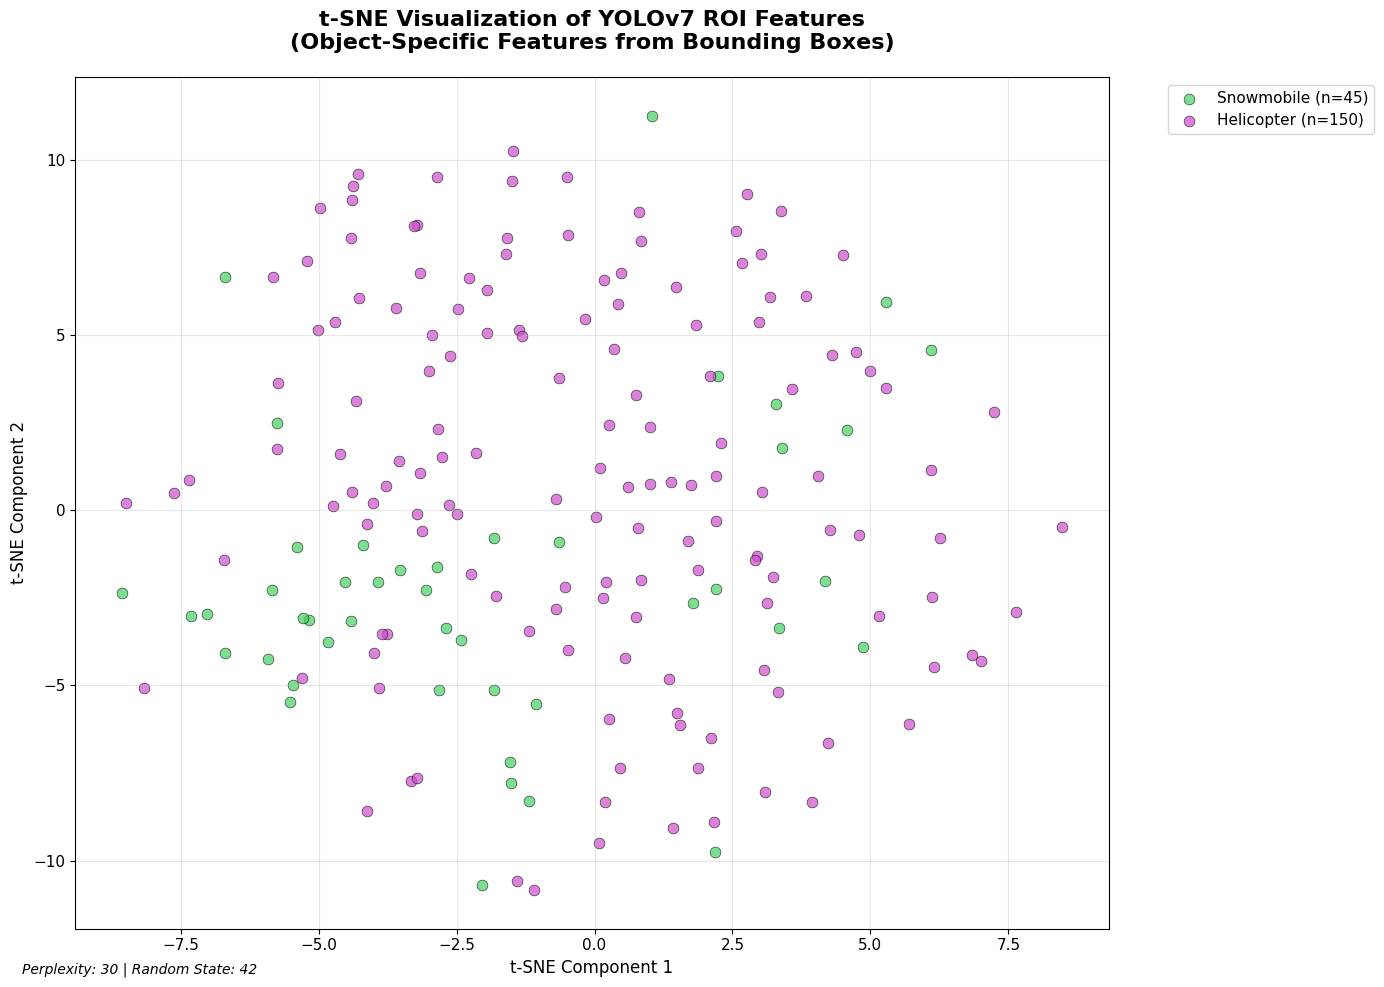


📈 t-SNE Analysis:
   Embedding shape: (195, 2)
   Silhouette Score: 0.060 (higher = better separation)

📏 Distance Analysis:
   Snowmobile within-class distance: 52.809
   Helicopter within-class distance: 108.169

📊 FEATURE STATISTICS:
Feature vector size: 256
Feature range: [-0.2785, 8.1746]
Feature mean: 0.2375
Feature std: 0.3386

Snowmobile features:
   Count: 45
   Mean: 0.2408
   Std: 0.4174
   Range: [-0.2785, 8.1746]

Helicopter features:
   Count: 150
   Mean: 0.2365
   Std: 0.3110
   Range: [-0.2784, 4.5537]


In [20]:
# 🎯 EXECUTE: Collect features for three classes
class_names = ["Snowmobile", "Helicopter"]

data_root = "/home/ehajizad/dev/OIDv4_ToolKit/OID/Dataset/test"

# Collect ROI-based features with labels
features_array, labels_array, metadata = collect_class_features(
    class_names=class_names,
    data_root=data_root,
    model=model,
    max_samples_per_class=150,  # Limit to 30 samples per class for faster processing
    conf_threshold=0.02
)

if features_array is not None:
    print(f"\n💾 SAVING FEATURES AND LABELS...")
    
    # Save features and labels for later use
    np.save('bbox_features_3_classes.npy', features_array)
    np.save('labels_3_classes.npy', labels_array)
    
    # Save metadata as well
    import pickle
    with open('metadata_3_classes.pkl', 'wb') as f:
        pickle.dump(metadata, f)
    
    print(f"✅ Saved:")
    print(f"   - bbox_features_3_classes.npy: {features_array.shape}")
    print(f"   - labels_3_classes.npy: {labels_array.shape}")
    print(f"   - metadata_3_classes.pkl: {len(metadata)} samples")
    
    # Create t-SNE visualization
    print(f"\n🎨 CREATING T-SNE VISUALIZATION...")
    tsne_features = plot_tsne_visualization(
        features=features_array,
        labels=labels_array,
        class_names=class_names,
        metadata=metadata,
        perplexity=min(30, len(features_array)//4),  # Adjust perplexity based on data size
        random_state=42,
        figsize=(14, 10)
    )
    
    # Additional analysis: Feature statistics
    print(f"\n📊 FEATURE STATISTICS:")
    print(f"Feature vector size: {features_array.shape[1]}")
    print(f"Feature range: [{features_array.min():.4f}, {features_array.max():.4f}]")
    print(f"Feature mean: {features_array.mean():.4f}")
    print(f"Feature std: {features_array.std():.4f}")
    
    # Per-class statistics
    for class_idx, class_name in enumerate(class_names):
        class_mask = labels_array == class_idx
        if np.any(class_mask):
            class_features = features_array[class_mask]
            print(f"\n{class_name} features:")
            print(f"   Count: {len(class_features)}")
            print(f"   Mean: {class_features.mean():.4f}")
            print(f"   Std: {class_features.std():.4f}")
            print(f"   Range: [{class_features.min():.4f}, {class_features.max():.4f}]")

else:
    print("❌ Failed to collect features. Check your data paths and model setup.")

🔍 Checking for saved features...
✅ Loaded saved features:
   Features: (195, 256)
   Labels: (195,)
   Metadata: 195 samples

🚀 Running comprehensive analysis on saved features...
🎨 Creating t-SNE visualizations with different perplexities...


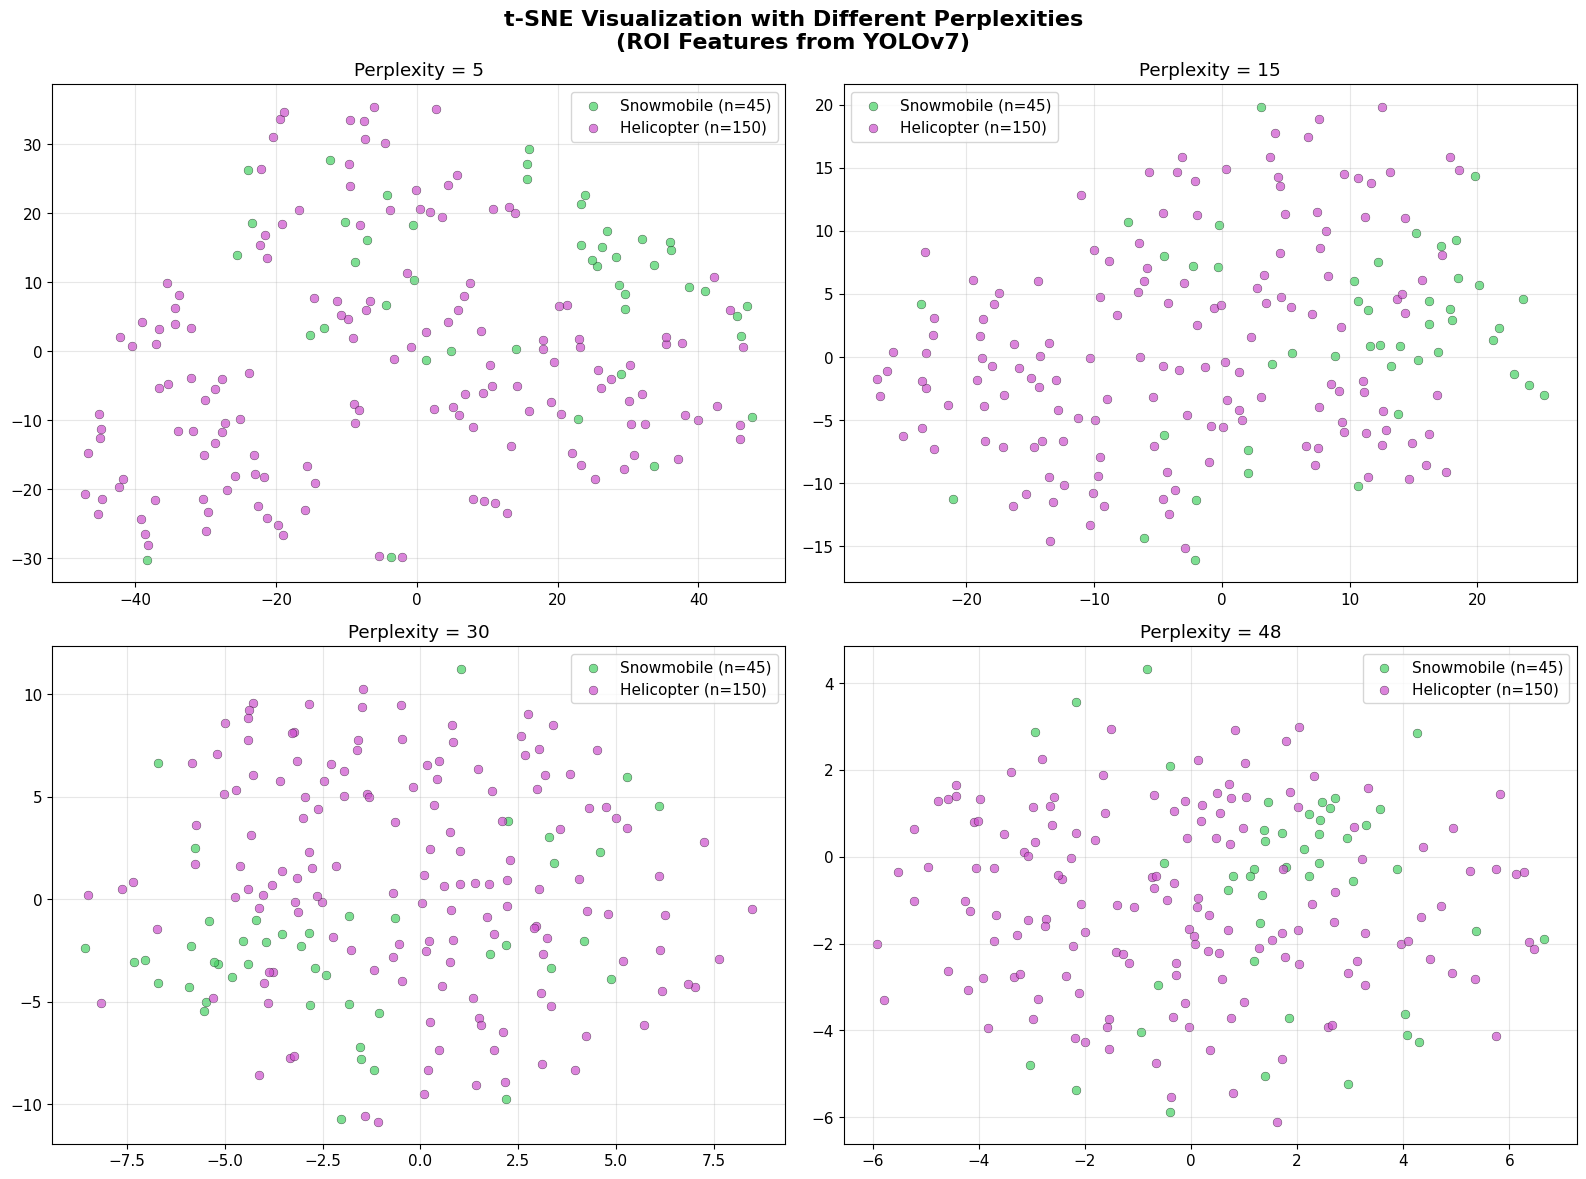


📊 Creating feature distribution analysis...


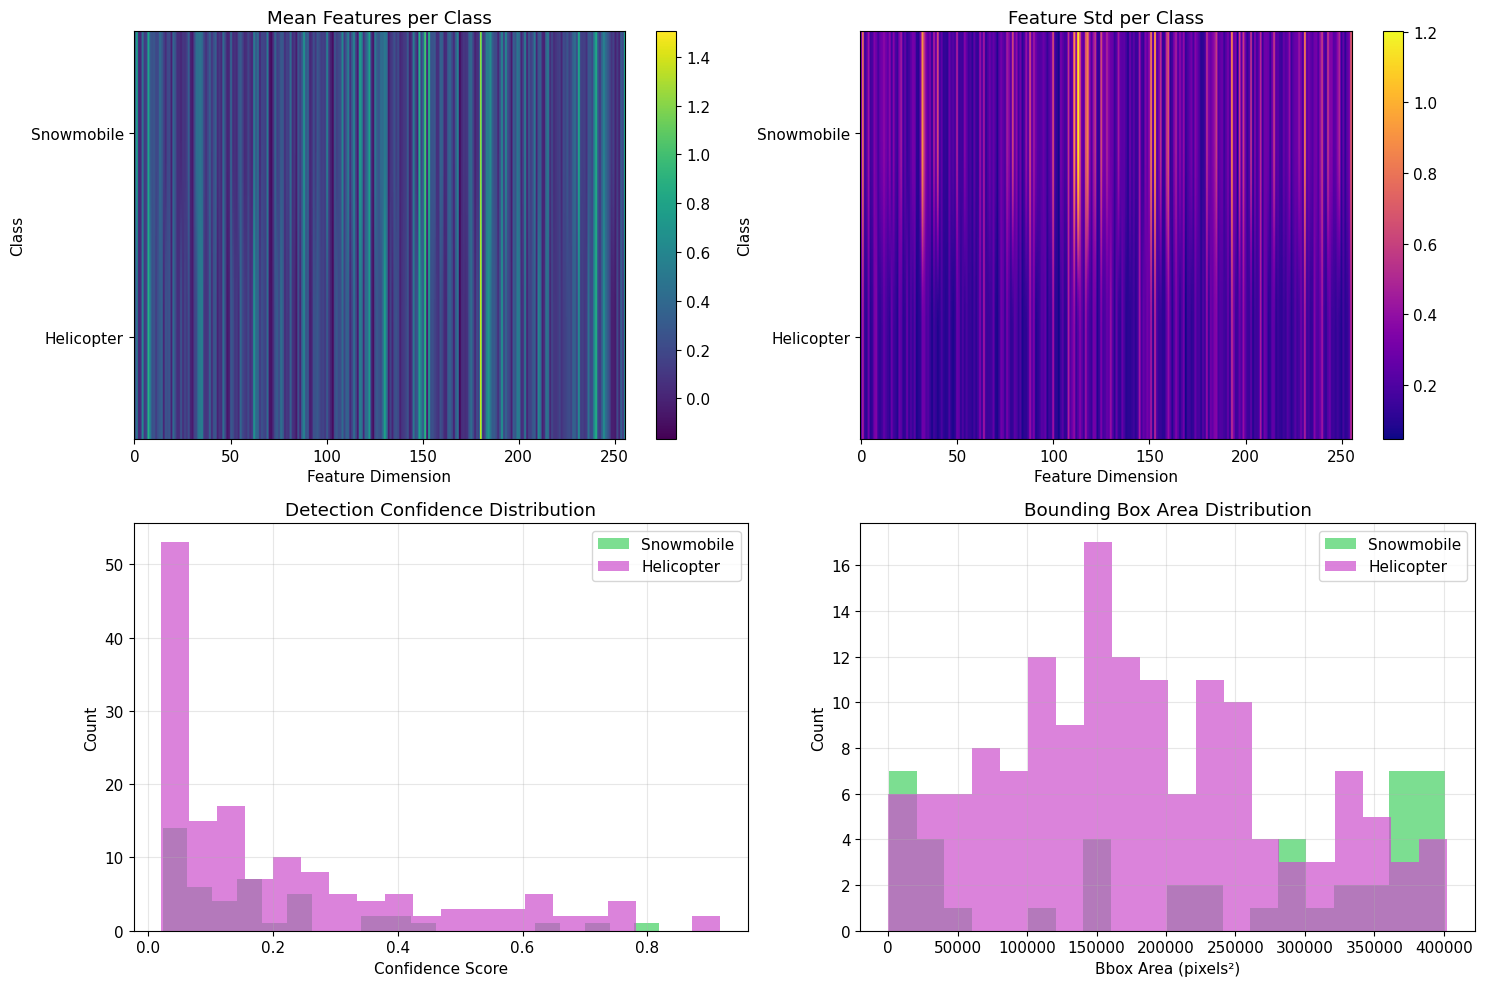


🎯 Classification Readiness Analysis:
   Random Forest Accuracy: 0.831
   Training samples: 136
   Test samples: 59
   Top 5 most important features: [210 130 149 147  54]
   SVM Accuracy: 0.881


In [21]:
# 📈 ADDITIONAL ANALYSIS AND VISUALIZATIONS
%matplotlib inline
def load_saved_features():
    """Load previously saved features, labels, and metadata."""
    try:
        features = np.load('bbox_features_3_classes.npy')
        labels = np.load('labels_3_classes.npy')
        
        with open('metadata_3_classes.pkl', 'rb') as f:
            metadata = pickle.load(f)
        
        print(f"✅ Loaded saved features:")
        print(f"   Features: {features.shape}")
        print(f"   Labels: {labels.shape}")
        print(f"   Metadata: {len(metadata)} samples")
        
        return features, labels, metadata
    except FileNotFoundError:
        print("❌ Saved features not found. Run the collection first.")
        return None, None, None

def create_comprehensive_analysis(features, labels, class_names, metadata):
    """Create comprehensive analysis including multiple visualizations."""
    
    # 1. t-SNE with different perplexities
    print("🎨 Creating t-SNE visualizations with different perplexities...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    perplexities = [5, 15, 30, 50]
    
    # Standardize features once
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    colors = ["#45D163", "#CD4ECD", "#FF6B6B"]

    for i, perp in enumerate(perplexities):
        ax = axes[i//2, i%2]
        
        # Adjust perplexity if too large for dataset
        actual_perp = min(perp, len(features)//4)
        
        tsne = TSNE(n_components=2, perplexity=actual_perp, random_state=42, max_iter=1000)
        features_2d = tsne.fit_transform(features_scaled)
        
        for class_idx, class_name in enumerate(class_names):
            mask = labels == class_idx
            if np.any(mask):
                ax.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                          c=colors[class_idx], label=f"{class_name} (n={np.sum(mask)})",
                          alpha=0.7, s=40, edgecolors='black', linewidth=0.3)
        
        ax.set_title(f'Perplexity = {actual_perp}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('t-SNE Visualization with Different Perplexities\n(ROI Features from YOLOv7)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 2. Feature distribution analysis
    print("\n📊 Creating feature distribution analysis...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Feature means per class
    ax1 = axes[0, 0]
    class_means = []
    for class_idx, class_name in enumerate(class_names):
        mask = labels == class_idx
        if np.any(mask):
            class_means.append(features[mask].mean(axis=0))
    
    if class_means:
        class_means = np.array(class_means)
        im1 = ax1.imshow(class_means, aspect='auto', cmap='viridis')
        ax1.set_title('Mean Features per Class')
        ax1.set_ylabel('Class')
        ax1.set_xlabel('Feature Dimension')
        ax1.set_yticks(range(len(class_names)))
        ax1.set_yticklabels(class_names)
        plt.colorbar(im1, ax=ax1)
    
    # Feature variance per class
    ax2 = axes[0, 1]
    class_stds = []
    for class_idx, class_name in enumerate(class_names):
        mask = labels == class_idx
        if np.any(mask):
            class_stds.append(features[mask].std(axis=0))
    
    if class_stds:
        class_stds = np.array(class_stds)
        im2 = ax2.imshow(class_stds, aspect='auto', cmap='plasma')
        ax2.set_title('Feature Std per Class')
        ax2.set_ylabel('Class')
        ax2.set_xlabel('Feature Dimension')
        ax2.set_yticks(range(len(class_names)))
        ax2.set_yticklabels(class_names)
        plt.colorbar(im2, ax=ax2)
    
    # Confidence distribution
    ax3 = axes[1, 0]
    for class_idx, class_name in enumerate(class_names):
        class_metadata = [m for m in metadata if m['class_id'] == class_idx]
        confidences = [m['confidence'] for m in class_metadata]
        if confidences:
            ax3.hist(confidences, bins=20, alpha=0.7, label=class_name, color=colors[class_idx])
    
    ax3.set_title('Detection Confidence Distribution')
    ax3.set_xlabel('Confidence Score')
    ax3.set_ylabel('Count')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Bounding box size distribution - FIX TENSOR CONVERSION ISSUE
    ax4 = axes[1, 1]
    for class_idx, class_name in enumerate(class_names):
        class_metadata = [m for m in metadata if m['class_id'] == class_idx]
        bbox_areas = []
        for m in class_metadata:
            bbox = m['bbox']
            
            # Handle different bbox formats - convert tensors to numpy if needed
            if hasattr(bbox, 'cpu'):  # PyTorch tensor
                bbox = bbox.cpu().numpy()
            elif hasattr(bbox, '__iter__') and hasattr(bbox[0], 'cpu'):  # List/tuple of tensors
                bbox = [x.cpu().numpy() if hasattr(x, 'cpu') else x for x in bbox]
            
            # Extract coordinates safely
            if len(bbox) >= 4:
                x1, y1, x2, y2 = bbox[:4]
                area = (x2 - x1) * (y2 - y1)
                bbox_areas.append(float(area))  # Ensure it's a Python float
        
        if bbox_areas:
            ax4.hist(bbox_areas, bins=20, alpha=0.7, label=class_name, color=colors[class_idx])
    
    ax4.set_title('Bounding Box Area Distribution')
    ax4.set_xlabel('Bbox Area (pixels²)')
    ax4.set_ylabel('Count')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Classification readiness analysis
    print("\n🎯 Classification Readiness Analysis:")
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.metrics import classification_report, accuracy_score
    
    # Simple classification test
    if len(np.unique(labels)) > 1:
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.3, random_state=42, stratify=labels
        )
        
        # Train a simple classifier
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        
        # Predictions
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"   Random Forest Accuracy: {accuracy:.3f}")
        print(f"   Training samples: {len(X_train)}")
        print(f"   Test samples: {len(X_test)}")
        
        # Feature importance
        feature_importance = clf.feature_importances_
        print(f"   Top 5 most important features: {np.argsort(feature_importance)[-5:]}")
        
        # Train a simple classifier
        clf = SVC(random_state=42, kernel='linear', C=1.0, gamma='scale', max_iter=1000)
        clf.fit(X_train, y_train)
        
        # Predictions
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"   SVM Accuracy: {accuracy:.3f}")
        
        return True
    else:
        print("   ⚠️ Need at least 2 classes for classification analysis")
        return False

# Optional: Run analysis on saved features if they exist
print("🔍 Checking for saved features...")
saved_features, saved_labels, saved_metadata = load_saved_features()

if saved_features is not None:
    print("\n🚀 Running comprehensive analysis on saved features...")
    create_comprehensive_analysis(saved_features, saved_labels, class_names, saved_metadata)
else:
    print("💡 Run the feature collection cell above first to generate visualizations!")